### Get Data into correct DataFrame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from statsforecast.models import ETS
from statsforecast import StatsForecast
from statsmodels.tsa.tsatools import detrend
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsforecast.models import AutoETS

In [2]:
### get data
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/sjsimmo2/TimeSeries/master/energy_F2024.csv")

df.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,8/1/2018 4:00,8/1/2018 0:00,RFC,WEST,AEP,AEPAPT,4050.612,True
1,8/1/2018 5:00,8/1/2018 1:00,RFC,WEST,AEP,AEPAPT,3855.341,True
2,8/1/2018 6:00,8/1/2018 2:00,RFC,WEST,AEP,AEPAPT,3744.805,True
3,8/1/2018 7:00,8/1/2018 3:00,RFC,WEST,AEP,AEPAPT,3665.854,True
4,8/1/2018 8:00,8/1/2018 4:00,RFC,WEST,AEP,AEPAPT,3681.299,True


In [3]:
### use the ept_time

df = df.drop(columns=['datetime_beginning_utc'])

In [4]:
df.columns

Index(['datetime_beginning_ept', 'nerc_region', 'mkt_region', 'zone',
       'load_area', 'mw', 'is_verified'],
      dtype='object')

##### For this assignment, you will need to roll up the data to TOTAL AVERAGE DAILY usage by month and answer the following questions (i.e. find the total daily usage and then roll this up to get the average total daily usage for each month).

In [5]:
### convert the column to a datetime object, then drop the hour component
df['datetime_beginning_ept'] = pd.to_datetime(df['datetime_beginning_ept'])
df['datetime_beginning_ept'] = df['datetime_beginning_ept'].dt.date

In [6]:
df.head(10)

,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2018-08-01,RFC,WEST,AEP,AEPAPT,4050.612,True
1,2018-08-01,RFC,WEST,AEP,AEPAPT,3855.341,True
2,2018-08-01,RFC,WEST,AEP,AEPAPT,3744.805,True
3,2018-08-01,RFC,WEST,AEP,AEPAPT,3665.854,True
4,2018-08-01,RFC,WEST,AEP,AEPAPT,3681.299,True
5,2018-08-01,RFC,WEST,AEP,AEPAPT,3794.360,True
6,2018-08-01,RFC,WEST,AEP,AEPAPT,4021.192,True
7,2018-08-01,RFC,WEST,AEP,AEPAPT,4217.335,True
8,2018-08-01,RFC,WEST,AEP,AEPAPT,4394.209,True
9,2018-08-01,RFC,WEST,AEP,AEPAPT,4595.715,True


In [7]:
df.is_verified.value_counts()

is_verified
True    52608
Name: count, dtype: int64

In [8]:
df = df.drop(columns=['is_verified'])
df.head()

,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw
0,2018-08-01,RFC,WEST,AEP,AEPAPT,4050.612
1,2018-08-01,RFC,WEST,AEP,AEPAPT,3855.341
2,2018-08-01,RFC,WEST,AEP,AEPAPT,3744.805
3,2018-08-01,RFC,WEST,AEP,AEPAPT,3665.854
4,2018-08-01,RFC,WEST,AEP,AEPAPT,3681.299


In [9]:
### now we need to aggregate each observation from being an hour in a day, to a day in a month. This will make the df
### a Series, and we will transform it back in a df after we resest the index in the next step

df = df.groupby(['datetime_beginning_ept','nerc_region','mkt_region','zone','load_area'])['mw'].sum()

df

datetime_beginning_ept  nerc_region  mkt_region  zone  load_area
2018-08-01              RFC          WEST        AEP   AEPAPT       110120.449
2018-08-02              RFC          WEST        AEP   AEPAPT       108871.637
2018-08-03              RFC          WEST        AEP   AEPAPT       106642.465
2018-08-04              RFC          WEST        AEP   AEPAPT       108985.285
2018-08-05              RFC          WEST        AEP   AEPAPT       110821.779
                                                                       ...    
2024-07-27              RFC          WEST        AEP   AEPAPT       103531.864
2024-07-28              RFC          WEST        AEP   AEPAPT       103796.881
2024-07-29              RFC          WEST        AEP   AEPAPT       109841.511
2024-07-30              RFC          WEST        AEP   AEPAPT       112083.318
2024-07-31              RFC          WEST        AEP   AEPAPT       117163.978
Name: mw, Length: 2192, dtype: float64

In [10]:
### convert it back to a dataframe, with df.reset_index()

df = df.reset_index()
df['datetime_beginning_ept'] = pd.to_datetime(df['datetime_beginning_ept'])
df['datetime_beginning_ept'] = df['datetime_beginning_ept'].dt.date
df.head()

,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw
0,2018-08-01,RFC,WEST,AEP,AEPAPT,110120.449
1,2018-08-02,RFC,WEST,AEP,AEPAPT,108871.637
2,2018-08-03,RFC,WEST,AEP,AEPAPT,106642.465
3,2018-08-04,RFC,WEST,AEP,AEPAPT,108985.285
4,2018-08-05,RFC,WEST,AEP,AEPAPT,110821.779


In [11]:
df.dtypes

datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
dtype: object

In [12]:
df['datetime_beginning_ept'] = pd.to_datetime(df['datetime_beginning_ept'])
df['days_in_month'] = df['datetime_beginning_ept'].dt.day
df.head()

,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,days_in_month
0,2018-08-01,RFC,WEST,AEP,AEPAPT,110120.449,1
1,2018-08-02,RFC,WEST,AEP,AEPAPT,108871.637,2
2,2018-08-03,RFC,WEST,AEP,AEPAPT,106642.465,3
3,2018-08-04,RFC,WEST,AEP,AEPAPT,108985.285,4
4,2018-08-05,RFC,WEST,AEP,AEPAPT,110821.779,5


In [13]:
### get the yyyy-mm combo

df['yyyy_mm'] = df['datetime_beginning_ept'].dt.to_period('M')

df.head()



,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,days_in_month,yyyy_mm
0,2018-08-01,RFC,WEST,AEP,AEPAPT,110120.449,1,2018-08
1,2018-08-02,RFC,WEST,AEP,AEPAPT,108871.637,2,2018-08
2,2018-08-03,RFC,WEST,AEP,AEPAPT,106642.465,3,2018-08
3,2018-08-04,RFC,WEST,AEP,AEPAPT,108985.285,4,2018-08
4,2018-08-05,RFC,WEST,AEP,AEPAPT,110821.779,5,2018-08


In [14]:
### get the max day from the yyyy-mm combo

df['max_day_in_month'] = df.groupby('yyyy_mm')['days_in_month'].transform('max')

df.head()

,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,days_in_month,yyyy_mm,max_day_in_month
0,2018-08-01,RFC,WEST,AEP,AEPAPT,110120.449,1,2018-08,31
1,2018-08-02,RFC,WEST,AEP,AEPAPT,108871.637,2,2018-08,31
2,2018-08-03,RFC,WEST,AEP,AEPAPT,106642.465,3,2018-08,31
3,2018-08-04,RFC,WEST,AEP,AEPAPT,108985.285,4,2018-08,31
4,2018-08-05,RFC,WEST,AEP,AEPAPT,110821.779,5,2018-08,31


In [15]:
df = df.drop(columns=['yyyy_mm','days_in_month'])

df.head()

,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,max_day_in_month
0,2018-08-01,RFC,WEST,AEP,AEPAPT,110120.449,31
1,2018-08-02,RFC,WEST,AEP,AEPAPT,108871.637,31
2,2018-08-03,RFC,WEST,AEP,AEPAPT,106642.465,31
3,2018-08-04,RFC,WEST,AEP,AEPAPT,108985.285,31
4,2018-08-05,RFC,WEST,AEP,AEPAPT,110821.779,31


In [16]:
df['month_year'] = df['datetime_beginning_ept'].dt.to_period('M')

In [17]:
df_month = df.drop(columns=['datetime_beginning_ept'])


In [18]:
df_month.head(5)

,nerc_region,mkt_region,zone,load_area,mw,max_day_in_month,month_year
0,RFC,WEST,AEP,AEPAPT,110120.449,31,2018-08
1,RFC,WEST,AEP,AEPAPT,108871.637,31,2018-08
2,RFC,WEST,AEP,AEPAPT,106642.465,31,2018-08
3,RFC,WEST,AEP,AEPAPT,108985.285,31,2018-08
4,RFC,WEST,AEP,AEPAPT,110821.779,31,2018-08


In [19]:
df_month_agg = df_month.groupby(['nerc_region','mkt_region','zone','load_area','max_day_in_month','month_year'])['mw'].sum()
df_month_agg

nerc_region  mkt_region  zone  load_area  max_day_in_month  month_year
RFC          WEST        AEP   AEPAPT     28                2019-02       3275952.712
                                                            2021-02       3532369.258
                                                            2022-02       3340456.103
                                                            2023-02       2999227.176
                                          29                2020-02       3392013.933
                                                                             ...     
                                          31                2023-12       3448270.505
                                                            2024-01       3932111.543
                                                            2024-03       2965310.501
                                                            2024-05       2863142.963
                                                            2024-07  

In [20]:
df_month_agg = df_month_agg.reset_index()
df_month_agg

,nerc_region,mkt_region,zone,load_area,max_day_in_month,month_year,mw
0,RFC,WEST,AEP,AEPAPT,28,2019-02,3275952.712
1,RFC,WEST,AEP,AEPAPT,28,2021-02,3532369.258
2,RFC,WEST,AEP,AEPAPT,28,2022-02,3340456.103
3,RFC,WEST,AEP,AEPAPT,28,2023-02,2999227.176
4,RFC,WEST,AEP,AEPAPT,29,2020-02,3392013.933
...,...,...,...,...,...,...,...
67,RFC,WEST,AEP,AEPAPT,31,2023-12,3448270.505
68,RFC,WEST,AEP,AEPAPT,31,2024-01,3932111.543
69,RFC,WEST,AEP,AEPAPT,31,2024-03,2965310.501
70,RFC,WEST,AEP,AEPAPT,31,2024-05,2863142.963


In [21]:
df_month_agg.rename(columns ={'mw':'mw_sum'}, inplace=True)
df_month_agg.head()

,nerc_region,mkt_region,zone,load_area,max_day_in_month,month_year,mw_sum
0,RFC,WEST,AEP,AEPAPT,28,2019-02,3275952.712
1,RFC,WEST,AEP,AEPAPT,28,2021-02,3532369.258
2,RFC,WEST,AEP,AEPAPT,28,2022-02,3340456.103
3,RFC,WEST,AEP,AEPAPT,28,2023-02,2999227.176
4,RFC,WEST,AEP,AEPAPT,29,2020-02,3392013.933


In [22]:
df_month_agg['mw_daily_avg'] = df_month_agg.mw_sum/df_month_agg.max_day_in_month
df_month_agg.head()

,nerc_region,mkt_region,zone,load_area,max_day_in_month,month_year,mw_sum,mw_daily_avg
0,RFC,WEST,AEP,AEPAPT,28,2019-02,3275952.712,116998.311143
1,RFC,WEST,AEP,AEPAPT,28,2021-02,3532369.258,126156.044929
2,RFC,WEST,AEP,AEPAPT,28,2022-02,3340456.103,119302.003679
3,RFC,WEST,AEP,AEPAPT,28,2023-02,2999227.176,107115.256286
4,RFC,WEST,AEP,AEPAPT,29,2020-02,3392013.933,116965.997690


In [23]:
# now make month_year the index

df_month_agg['month_year'] = pd.to_datetime(df_month_agg['month_year'].astype(str), format='%Y-%m')
df_month_agg.set_index('month_year', inplace=True)
df_month_agg.sort_index(inplace=True)
df_month_agg.head()



,nerc_region,mkt_region,zone,load_area,max_day_in_month,mw_sum,mw_daily_avg
month_year,,,,,,,
2018-08-01,RFC,WEST,AEP,AEPAPT,31,3479278.136,112234.778581
2018-09-01,RFC,WEST,AEP,AEPAPT,30,3184945.980,106164.866000
2018-10-01,RFC,WEST,AEP,AEPAPT,31,3132505.778,101048.573484
2018-11-01,RFC,WEST,AEP,AEPAPT,30,3308889.192,110296.306400
2018-12-01,RFC,WEST,AEP,AEPAPT,31,3711803.067,119735.582806


In [24]:
df_month_agg.index.name = None
df_month_agg.head()

,nerc_region,mkt_region,zone,load_area,max_day_in_month,mw_sum,mw_daily_avg
2018-08-01,RFC,WEST,AEP,AEPAPT,31,3479278.136,112234.778581
2018-09-01,RFC,WEST,AEP,AEPAPT,30,3184945.980,106164.866000
2018-10-01,RFC,WEST,AEP,AEPAPT,31,3132505.778,101048.573484
2018-11-01,RFC,WEST,AEP,AEPAPT,30,3308889.192,110296.306400
2018-12-01,RFC,WEST,AEP,AEPAPT,31,3711803.067,119735.582806


In [25]:
df_month_agg.head(25)

,nerc_region,mkt_region,zone,load_area,max_day_in_month,mw_sum,mw_daily_avg
2018-08-01,RFC,WEST,AEP,AEPAPT,31,3479278.136,112234.778581
2018-09-01,RFC,WEST,AEP,AEPAPT,30,3184945.980,106164.866000
2018-10-01,RFC,WEST,AEP,AEPAPT,31,3132505.778,101048.573484
2018-11-01,RFC,WEST,AEP,AEPAPT,30,3308889.192,110296.306400
2018-12-01,RFC,WEST,AEP,AEPAPT,31,3711803.067,119735.582806
2019-01-01,RFC,WEST,AEP,AEPAPT,31,4041373.165,130366.876290
2019-02-01,RFC,WEST,AEP,AEPAPT,28,3275952.712,116998.311143
2019-03-01,RFC,WEST,AEP,AEPAPT,31,3455634.552,111472.082323
2019-04-01,RFC,WEST,AEP,AEPAPT,30,2831890.199,94396.339967
2019-05-01,RFC,WEST,AEP,AEPAPT,31,3057063.714,98614.958516


In [26]:
final_df = df_month_agg.drop(columns=['max_day_in_month'])

In [27]:
final_df.head()

,nerc_region,mkt_region,zone,load_area,mw_sum,mw_daily_avg
2018-08-01,RFC,WEST,AEP,AEPAPT,3479278.136,112234.778581
2018-09-01,RFC,WEST,AEP,AEPAPT,3184945.980,106164.866000
2018-10-01,RFC,WEST,AEP,AEPAPT,3132505.778,101048.573484
2018-11-01,RFC,WEST,AEP,AEPAPT,3308889.192,110296.306400
2018-12-01,RFC,WEST,AEP,AEPAPT,3711803.067,119735.582806


In [28]:
energy_train = final_df['2018-08-01':'2022-07-01']
energy_validate = final_df['2022-08-01':'2023-07-01']
energy_test = final_df['2023-08-01':'2024-07-01']

In [29]:
print(energy_train.tail(2))

print(energy_validate.head(2))
print(energy_validate.tail(2))

print(energy_test.head(2))
print(energy_test.tail(2))

           nerc_region mkt_region zone load_area       mw_sum   mw_daily_avg
2022-06-01         RFC       WEST  AEP    AEPAPT  3144455.981  104815.199367
2022-07-01         RFC       WEST  AEP    AEPAPT  3407835.341  109930.172290
           nerc_region mkt_region zone load_area       mw_sum   mw_daily_avg
2022-08-01         RFC       WEST  AEP    AEPAPT  3323563.963  107211.740742
2022-09-01         RFC       WEST  AEP    AEPAPT  2869851.814   95661.727133
           nerc_region mkt_region zone load_area       mw_sum   mw_daily_avg
2023-06-01         RFC       WEST  AEP    AEPAPT  2825087.479   94169.582633
2023-07-01         RFC       WEST  AEP    AEPAPT  3315745.786  106959.541484
           nerc_region mkt_region zone load_area       mw_sum   mw_daily_avg
2023-08-01         RFC       WEST  AEP    AEPAPT  3298905.379  106416.302548
2023-09-01         RFC       WEST  AEP    AEPAPT  2887543.028   96251.434267
           nerc_region mkt_region zone load_area       mw_sum   mw_daily_avg

### Time Series HW Questions:

#### 1. Using the total daily average by month in the training data set, what is the median value?

In [30]:
energy_train.mw_daily_avg.median()

106820.89638709677

#### 2. Decompose your training data by using the STL decomposition assuming there is a monthly seasonality .  Describe what you see in your decomposition .  Describe what you observe for each component (feel free to use other plots to help you describe seasonality and trend).  Which components explain the most variability? Use your Fs and Ft to help guide your discussions.

In [31]:
import matplotlib.pyplot as plt

In [32]:
energy_train.head(20)

,nerc_region,mkt_region,zone,load_area,mw_sum,mw_daily_avg
2018-08-01,RFC,WEST,AEP,AEPAPT,3479278.136,112234.778581
2018-09-01,RFC,WEST,AEP,AEPAPT,3184945.980,106164.866000
2018-10-01,RFC,WEST,AEP,AEPAPT,3132505.778,101048.573484
2018-11-01,RFC,WEST,AEP,AEPAPT,3308889.192,110296.306400
2018-12-01,RFC,WEST,AEP,AEPAPT,3711803.067,119735.582806
2019-01-01,RFC,WEST,AEP,AEPAPT,4041373.165,130366.876290
2019-02-01,RFC,WEST,AEP,AEPAPT,3275952.712,116998.311143
2019-03-01,RFC,WEST,AEP,AEPAPT,3455634.552,111472.082323
2019-04-01,RFC,WEST,AEP,AEPAPT,2831890.199,94396.339967
2019-05-01,RFC,WEST,AEP,AEPAPT,3057063.714,98614.958516


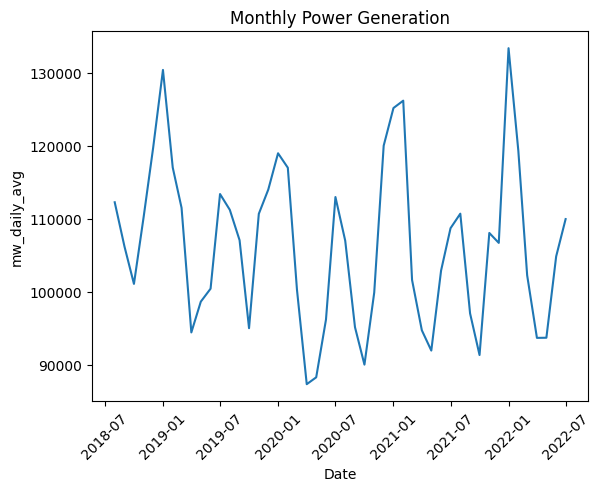

In [33]:
plt.plot(energy_train["mw_daily_avg"])
plt.xlabel("Date")
plt.ylabel("mw_daily_avg")
plt.title("Monthly Power Generation")
plt.xticks(rotation=45)
plt.show()

In [34]:
#libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from statsforecast import StatsForecast

In [35]:
## STL Decomposition

from statsforecast.models import MSTL

# format for the STL Decomp
d = {'unique_id': 1, 'ds': energy_train.index, 'y': energy_train['mw_daily_avg']}
energy_sf = pd.DataFrame(data = d)

dcmp = StatsForecast(models = [MSTL(season_length = 12)], freq = 'M')
dcmp.fit(df = energy_sf)

StatsForecast(models=[MSTL])

In [36]:
energy_sf.tail()

,unique_id,ds,y
2022-03-01,1,2022-03-01,102229.090032
2022-04-01,1,2022-04-01,93652.661867
2022-05-01,1,2022-05-01,93671.035065
2022-06-01,1,2022-06-01,104815.199367
2022-07-01,1,2022-07-01,109930.172290


In [37]:
result = dcmp.fitted_[0,0].model_
result.head()

,data,trend,seasonal,remainder
0,112234.778581,110944.915976,3187.114596,-1897.251991
1,106164.866000,110725.197074,-5111.232770,550.901696
2,101048.573484,110506.080384,-12165.577801,2708.070901
3,110296.306400,110288.770396,550.368433,-542.832429
4,119735.582806,110072.395665,9055.973005,607.214137


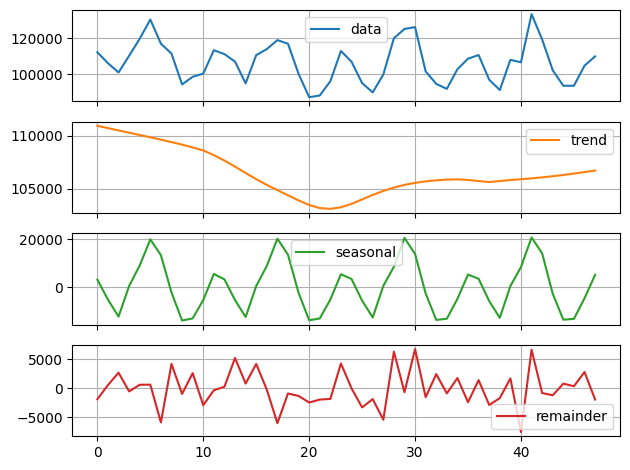

In [38]:
dcmp.fitted_[0, 0].model_.plot(subplots=True, grid=True)
## array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

plt.tight_layout()
plt.show()

### Trend Strength from an STL Decomposition

In [39]:
import numpy as np

# Extract components
trend = result['trend']
seasonal = result['seasonal']
residual = result['remainder']
data = result['data']  # Original data
t_and_r = trend + residual

# Ensure all series are aligned
if not trend.empty and not residual.empty and not seasonal.empty:
    # Calculate Trend Strength
    var_residual = residual.var()
    var_t_plus_r = t_and_r.var()
    var_detrended = (data - trend).var()

    if var_detrended == 0:
        trend_strength = 0
        print("Trend Strength: 0 (Detrended variance is zero)")
    else:
        trend_strength = 1 - (var_residual / var_t_plus_r)
        trend_strength = max(0, trend_strength)  # Avoid negative strength
        print(f"Trend Strength: {trend_strength:.2f}")

    # Calculate Seasonal Strength
    var_seasonal = seasonal.var()

    if var_detrended == 0:
        seasonal_strength = 0
        print("Seasonal Strength: 0 (Detrended variance is zero)")
    else:
        seasonal_strength = var_seasonal / var_detrended
        seasonal_strength = max(0, seasonal_strength)  # Avoid negative strength
        print(f"Seasonal Strength: {seasonal_strength:.2f}")
else:
    print("Trend, Seasonal, or Residual series is empty or misaligned.")


Trend Strength: 0.37
Seasonal Strength: 0.91


### Group HW

 Creation of easy to read and interpret visualizations of the following (ALL graphs MUST 
be of report ready quality):

- Visual of the training data set overlaid with the trend (be sure to indicate what 
type of decomposition was used).

- Time Plot of the predicted values and actual values for ONLY the validation data
set.

- Creation of the best ESM model.

- If the best ESM is a seasonal model, the client’s analysts are open to either additive or 
multiplicative ESM’s (be sure to specify this information IF a seasonal model is 
selected).

- The client uses Mean Absolute Percentage Error (MAPE) in calculating the accuracy of 
its forecasts. Report this measure for the forecasted electric load in the validation data. 


The client is open to other measurements in addition to the MAPE as long as they are 
clearly stated and supported.

#### 1. Plot the training data set with the trend overlaid

In [40]:
import seaborn as sns

In [41]:
import pandas as pd

# Assuming `result` is your DataFrame and you want to update the `ds` column
result2 = result.copy()

# Create a new date range starting from 2018-08-01, once per month for 48 periods (first day of the month)
result2['ds'] = pd.date_range(start="2018-08-01", freq="MS", periods=48)

# Preview the updated DataFrame with the first day of each month
result2.head()



,data,trend,seasonal,remainder,ds
0,112234.778581,110944.915976,3187.114596,-1897.251991,2018-08-01
1,106164.866000,110725.197074,-5111.232770,550.901696,2018-09-01
2,101048.573484,110506.080384,-12165.577801,2708.070901,2018-10-01
3,110296.306400,110288.770396,550.368433,-542.832429,2018-11-01
4,119735.582806,110072.395665,9055.973005,607.214137,2018-12-01


In [42]:
result2.sort_values(by='data', ascending=False).head(15)

,data,trend,seasonal,remainder,ds
41,133346.355581,105972.783922,20680.752351,6692.819308,2022-01-01
5,130366.876290,109855.184667,19886.585669,625.105954,2019-01-01
30,126156.044929,105544.612846,13799.846224,6811.585858,2021-02-01
29,125146.972129,105354.310689,20486.626886,-693.965446,2021-01-01
28,119989.103065,105098.348363,8531.281259,6359.473443,2020-12-01
4,119735.582806,110072.395665,9055.973005,607.214137,2018-12-01
42,119302.003679,106067.445838,14066.439884,-831.882044,2022-02-01
17,118948.631355,104857.350303,20162.682139,-6071.401088,2020-01-01
6,116998.311143,109633.849658,13303.916456,-5939.454971,2019-02-01
18,116965.997690,104370.401285,13502.855541,-907.259136,2020-02-01


In [43]:
result2.sort_values(by='data', ascending=False).tail(15)

,data,trend,seasonal,remainder,ds
27,99863.541867,104778.329067,555.588786,-5470.375987,2020-11-01
9,98614.958516,108900.548590,-12911.331149,2625.741075,2019-05-01
37,97003.812900,105620.732783,-5712.903792,-2904.016091,2021-09-01
22,96159.787300,103085.880225,-5070.092622,-1856.000303,2020-06-01
25,95115.571933,103976.802417,-5531.943664,-3329.286820,2020-09-01
14,94978.595355,106479.635681,-12314.067103,813.026777,2019-10-01
32,94694.360433,105783.562208,-13547.532349,2458.330574,2021-04-01
8,94396.339967,109161.560017,-13777.689177,-987.530874,2019-04-01
45,93671.035065,106422.438685,-13109.565795,358.162174,2022-05-01
44,93652.661867,106292.564046,-13441.538643,801.636463,2022-04-01


In [44]:
result2.tail()

,data,trend,seasonal,remainder,ds
43,102229.090032,106174.153313,-2724.807320,-1220.255961,2022-03-01
44,93652.661867,106292.564046,-13441.538643,801.636463,2022-04-01
45,93671.035065,106422.438685,-13109.565795,358.162174,2022-05-01
46,104815.199367,106562.810056,-4569.626546,2822.015856,2022-06-01
47,109930.172290,106711.844137,5177.907382,-1959.579229,2022-07-01


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

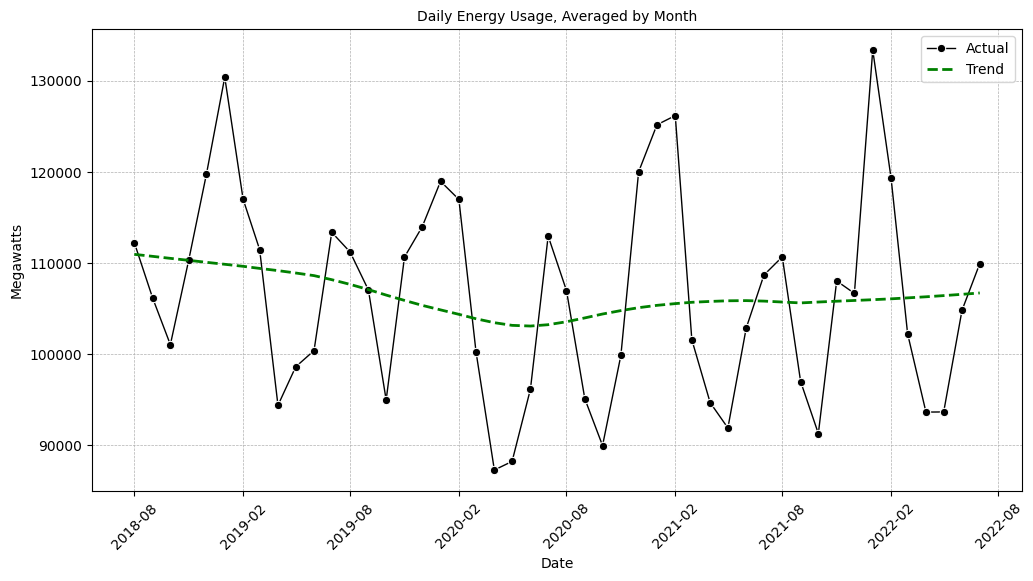

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Set a professional color palette (similar to the one in R, e.g., "deep")
sns.set_palette('deep')

# Create a wider figure (e.g., 12 inches wide, 6 inches tall)
plt.figure(figsize=(12, 6))

# Plot the 'Train' and 'Forecast' lines
sns.lineplot(data=energy_sf, x="ds", y="y", color="black", label="Actual", linewidth=1,  marker='o',)
sns.lineplot(data=result2, x="ds", y="trend", color="green", label="Trend", linestyle = '--', linewidth=2)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Add gridlines for better readability
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Set the x-axis to show ticks every 6 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show date as year-month

# Set labels and title for better clarity
plt.xlabel("Date", fontsize=10)
plt.ylabel("Megawatts", fontsize=10)
plt.title("Daily Energy Usage, Averaged by Month", fontsize=10)

# Display the legend (with Passengers and Trend)
plt.legend()

# Show the final plot
plt.show()


### 2. Create the best ESM Model
- graph it against the validate data

In [46]:
v = {'unique_id': 1, 'ds': energy_validate.index, 'y': energy_validate['mw_daily_avg']}
energy_v = pd.DataFrame(data = v)

In [47]:
# format for the STL Decomp
d = {'unique_id': 1, 'ds': energy_train.index, 'y': energy_train['mw_daily_avg']}
energy_sf = pd.DataFrame(data = d)

#### A. Auto-ETS

In [48]:
### AutoETS

energy_holtw = StatsForecast(models = [AutoETS(model=["Z","Z","Z"],  alias="AutoETS", season_length=12)], freq = 'M')
energy_model = energy_holtw.fit(df = energy_sf)

result = energy_holtw.fitted_[0,0].model_['par']
result

array([ 2.21350317e-01,             nan,  7.25980651e-04,             nan,
        1.10756797e+05,  5.40545293e+03, -4.93017818e+03, -1.33994131e+04,
       -1.36215899e+04, -2.93317806e+03,  1.36806550e+04,  2.08867464e+04,
        8.74254601e+03,  1.18542176e+03, -1.27670981e+04, -5.57476437e+03,
        3.32539954e+03])

In [49]:
y_hat_energy = energy_model.predict(h=24)

/opt/anaconda3/lib/python3.11/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

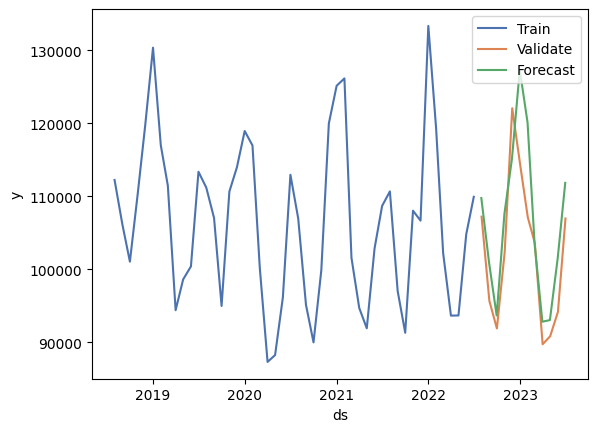

In [50]:
# 4. Build the forecast dataframe, then plot it

yhat=y_hat_energy.reset_index(drop=True)
forecast_at=pd.Series(pd.date_range("2022-07-01", freq="M", periods=12))
forecast_at=pd.DataFrame(forecast_at)
forecast_at.columns=["ds"]
forecast_at["hat"]=yhat['AutoETS']
forecast_at["unique_id"]="1"

sns.lineplot(energy_sf,x="ds", y="y", label="Train")
sns.lineplot(energy_v, x="ds", y="y", label="Validate")
sns.lineplot(forecast_at,x="ds", y="hat", label="Forecast",)
plt.show()

#### B. Additive Seasonality

In [51]:
### AutoETS

energy_holtw_a = StatsForecast(models = [AutoETS(model=["A","A","A"],  alias="AutoETS", season_length=12)], freq = 'M')
energy_model_a = energy_holtw_a.fit(df = energy_sf)

result = energy_holtw_a.fitted_[0,0].model_['par']
result

array([ 3.40400915e-02,  3.13206355e-04,  4.90730593e-03,  8.96309616e-01,
        1.13269795e+05, -9.80179386e+02,  5.62108560e+03, -4.75073879e+03,
       -1.27616667e+04, -1.35315613e+04, -2.68892993e+03,  1.36462597e+04,
        2.05444292e+04,  8.59412276e+03,  1.25053337e+03, -1.26872612e+04,
       -5.98774058e+03,  2.75146790e+03])

In [52]:
y_hat_energy_a = energy_model_a.predict(h=24)

/opt/anaconda3/lib/python3.11/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

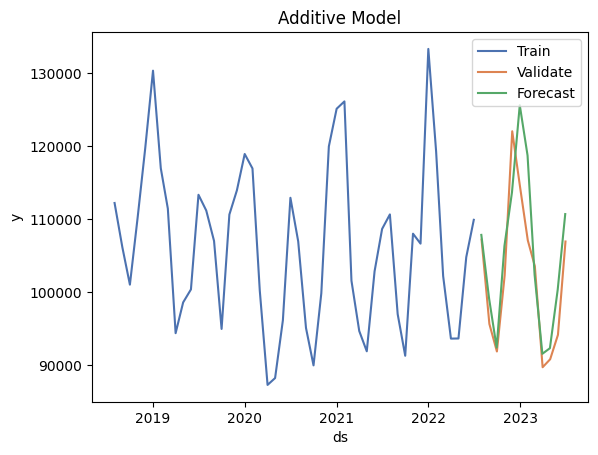

In [53]:
# 4. Build the forecast dataframe, then plot it

yhat_a=y_hat_energy_a.reset_index(drop=True)
forecast_a=pd.Series(pd.date_range("2022-07-01", freq="M", periods=12))
forecast_a=pd.DataFrame(forecast_a)
forecast_a.columns=["ds"]
forecast_a["hat"]=yhat_a['AutoETS']
forecast_a["unique_id"]="1"

sns.lineplot(energy_sf,x="ds", y="y", label="Train")
sns.lineplot(energy_v, x="ds", y="y", label="Validate")
sns.lineplot(forecast_a,x="ds", y="hat", label="Forecast",)
plt.title("Additive Model")
plt.show()

### C. Multiplicative

In [54]:
### AutoETS

energy_holtw_m = StatsForecast(models = [AutoETS(model=["M","A","M"],  alias="AutoETS", season_length=12)], freq = 'M')
energy_model_m = energy_holtw_m.fit(df = energy_sf)

result = energy_holtw_m.fitted_[0,0].model_['par']
result

array([ 2.13190007e-02,  1.99147426e-03,  2.90901612e-02,             nan,
        1.08348452e+05, -1.08049780e+02,  1.04703169e+00,  9.53526918e-01,
        8.76141472e-01,  8.72764233e-01,  9.78052812e-01,  1.12737425e+00,
        1.19584470e+00,  1.07960938e+00,  1.00285080e+00,  8.83754744e-01,
        9.50558229e-01,  1.03249078e+00])

In [55]:
y_hat_energy_m = energy_model_m.predict(h=24)

/opt/anaconda3/lib/python3.11/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

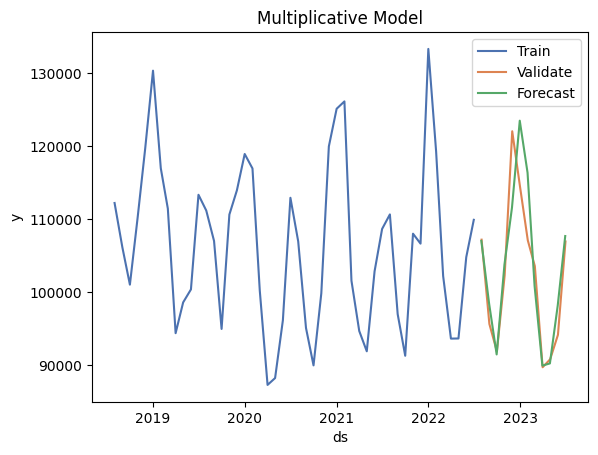

In [56]:
# 4. Build the forecast dataframe, then plot it

yhat_m=y_hat_energy_m.reset_index(drop=True)
forecast_m=pd.Series(pd.date_range("2022-07-01", freq="M", periods=12))
forecast_m=pd.DataFrame(forecast_m)
forecast_m.columns=["ds"]
forecast_m["hat"]=yhat_m['AutoETS']
forecast_m["unique_id"]="1"

sns.lineplot(energy_sf,x="ds", y="y", label="Train")
sns.lineplot(energy_v, x="ds", y="y", label="Validate")
sns.lineplot(forecast_m,x="ds", y="hat", label="Forecast",)
plt.title("Multiplicative Model")
plt.show()

#### 4. Accuracy

In [57]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("For HW Auto-ETS, here are the model accuracy scores")

# Assuming 'y_true' are the actual values and 'y_pred' are the predicted values from your model

# Example data (replace these with your actual data)
y_true = energy_v['y']
y_pred = forecast_at['hat']

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

# Calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape:.2f}%")


For HW Auto-ETS, here are the model accuracy scores
RMSE: 6696.35
MAE: 5428.02
MAPE: 5.18%


In [58]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("For HW Additive, here are the model accuracy scores")

# Assuming 'y_true' are the actual values and 'y_pred' are the predicted values from your model

# Example data (replace these with your actual data)
y_true = energy_v['y']
y_pred = forecast_a['hat']

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

# Calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape:.2f}%")


For HW Additive, here are the model accuracy scores
RMSE: 5903.35
MAE: 4522.67
MAPE: 4.26%


In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("For HW Multiplicative, here are the model accuracy scores")

# Assuming 'y_true' are the actual values and 'y_pred' are the predicted values from your model

# Example data (replace these with your actual data)
y_true = energy_v['y']
y_pred = forecast_m['hat']

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

# Calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape:.2f}%")


For HW Multiplicative, here are the model accuracy scores
RMSE: 5092.47
MAE: 3481.55
MAPE: 3.20%


### Final TS Project

- Creation of top 2 ARIMA models for forecasting megawatts per month (PJM would like 
nonseasonal ARIMA models….but you can be creative here and use information you already 
know).

o Comparison of these two models in terms of advantages and disadvantages (for 
example, how do they forecast, do they have white noise, stationarity, complexity 
of the model, etc).

o Plot of forecasted versus actual data in the validation data set (for both models)

o Measure of accuracy for the validation data set (for both models)

In [60]:
energy_train.head()

,nerc_region,mkt_region,zone,load_area,mw_sum,mw_daily_avg
2018-08-01,RFC,WEST,AEP,AEPAPT,3479278.136,112234.778581
2018-09-01,RFC,WEST,AEP,AEPAPT,3184945.980,106164.866000
2018-10-01,RFC,WEST,AEP,AEPAPT,3132505.778,101048.573484
2018-11-01,RFC,WEST,AEP,AEPAPT,3308889.192,110296.306400
2018-12-01,RFC,WEST,AEP,AEPAPT,3711803.067,119735.582806


In [61]:
# format for the Classical Decomp
d = {'unique_id': 1, 'ds': energy_train.index, 'y': energy_train['mw_daily_avg']}
energy_sf2 = pd.DataFrame(data = d)

In [62]:
energy_sf2.head()

,unique_id,ds,y
2018-08-01,1,2018-08-01,112234.778581
2018-09-01,1,2018-09-01,106164.866000
2018-10-01,1,2018-10-01,101048.573484
2018-11-01,1,2018-11-01,110296.306400
2018-12-01,1,2018-12-01,119735.582806


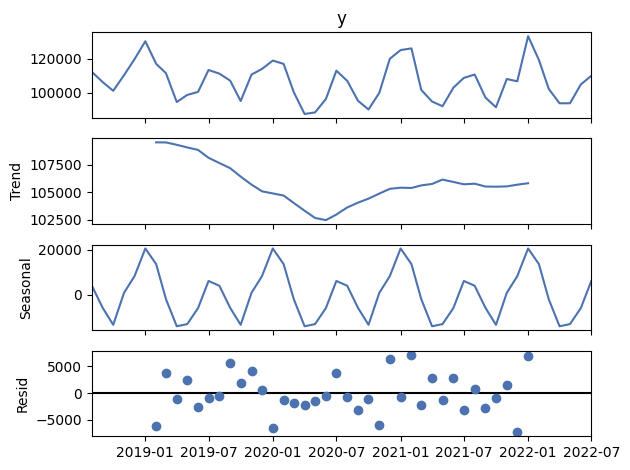

In [63]:
### Classic Decomposition - to get the constant seasonal componenet to add back in laster

decomp_df = seasonal_decompose(energy_sf2['y'], model = 'additive', period = 12)
decomp_df.plot()
plt.show()

In [64]:
# look at decomp df
trend = decomp_df.trend
seasonal = decomp_df.seasonal
residual = decomp_df.resid
data = decomp_df.observed

In [65]:
data.head(10)

2018-08-01    112234.778581
2018-09-01    106164.866000
2018-10-01    101048.573484
2018-11-01    110296.306400
2018-12-01    119735.582806
2019-01-01    130366.876290
2019-02-01    116998.311143
2019-03-01    111472.082323
2019-04-01     94396.339967
2019-05-01     98614.958516
Name: y, dtype: float64

In [66]:
# Fit the AR and MA components
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [67]:
# de-seasonalize the data
df = pd.DataFrame(data)
df.head()

,y
2018-08-01,112234.778581
2018-09-01,106164.866000
2018-10-01,101048.573484
2018-11-01,110296.306400
2018-12-01,119735.582806


In [68]:
df['y_deszn'] = data - seasonal
df.head()

,y,y_deszn
2018-08-01,112234.778581,108199.091228
2018-09-01,106164.866000,111930.831629
2018-10-01,101048.573484,114303.711857
2018-11-01,110296.306400,109380.421574
2018-12-01,119735.582806,111450.426716


In [69]:
# check the data for random walk - ADF to see if we need to difference it. High p-value, so we do not need to difference the data

adf_test = adfuller(df['y_deszn'])
adf_test[1]


0.06488592196147537

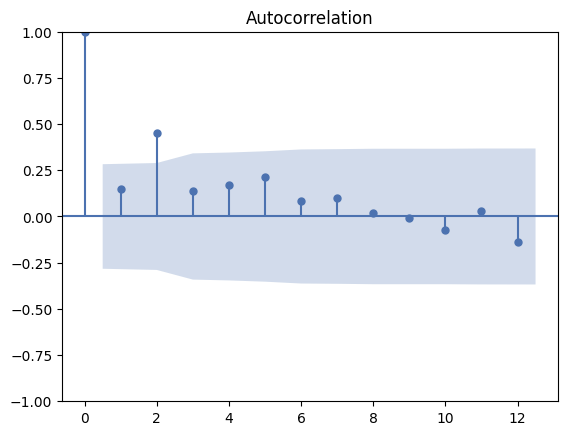

In [70]:
# Now fit the ARMA with PACF/ACF plots. One spike at 2 for ACF. So we will fit an MA term of 2

plot_acf(df['y_deszn'], lags=12)
plt.show()

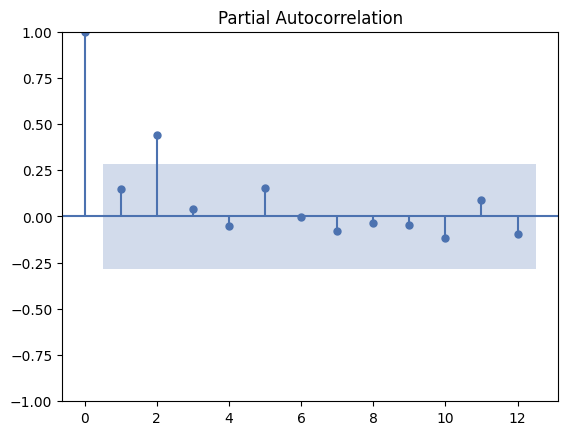

In [71]:
# Also a spike at 2 for the PACF, so we will fit an MA term of 2
plot_pacf(df['y_deszn'], lags=12)
plt.show()

In [72]:
df2 = df.drop(columns=['y'])
df2.head()

,y_deszn
2018-08-01,108199.091228
2018-09-01,111930.831629
2018-10-01,114303.711857
2018-11-01,109380.421574
2018-12-01,111450.426716


### ARIMA Model 1 - AR2, MA2

In [73]:
# fit the ARMA model

model1 = ARIMA(df2, order=(2,0,2))
model_fit = model1.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                y_deszn   No. Observations:                   48
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -461.753
Date:                Wed, 18 Sep 2024   AIC                            935.505
Time:                        08:59:17   BIC                            946.732
Sample:                    08-01-2018   HQIC                           939.748
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.064e+05   1222.894     87.009      0.000    1.04e+05    1.09e+05
ar.L1          0.2047      0.392      0.522      0.602      -0.564       0.974
ar.L2          0.4317      0.374      1.154      0.2

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


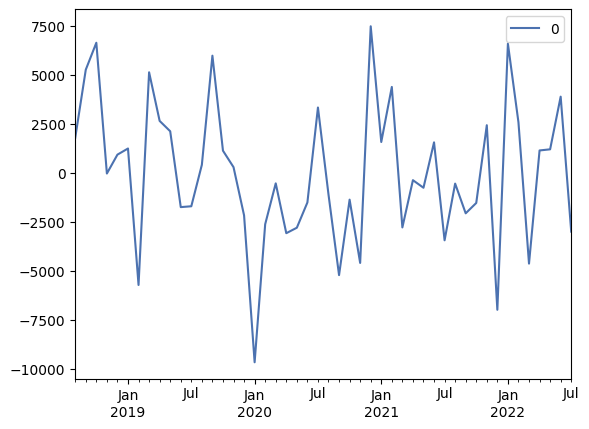

In [74]:
# now check the residuals for stationarity
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [75]:
residuals.describe()

,0
count,48.000000
mean,7.554925
std,3681.239242
min,-9635.680017
25%,-2265.673588
50%,-190.595311
75%,2208.464570
max,7479.389945


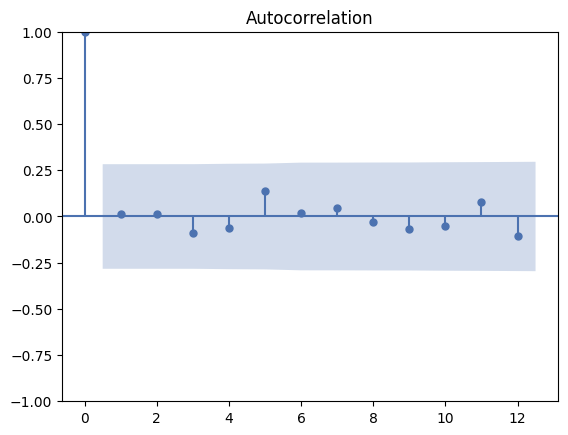

In [76]:
plot_acf(residuals,lags=12)
pyplot.show()

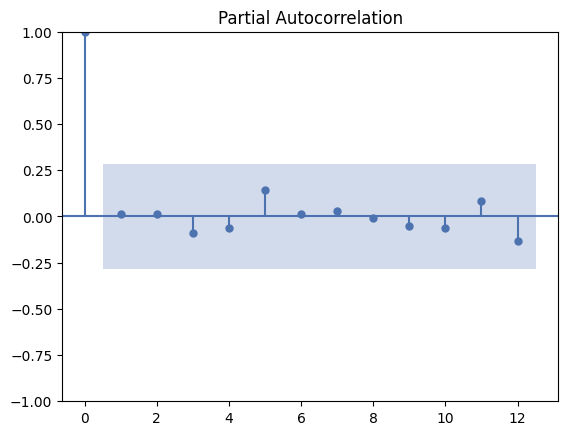

In [77]:
plot_pacf(residuals,lags=12)
pyplot.show()

In [78]:
import statsmodels.stats.diagnostic as diag

In [79]:
# Perform the Ljung-Box test
lb_test = diag.acorr_ljungbox(model_fit.resid, lags=[10], model_df=4)
print(lb_test)

     lb_stat  lb_pvalue
10  2.325071   0.887508


#### Takeaways:
- good model, and residuals pass the the assumptions for stationarity/white noise.
- will test more models, but this one is good enough for predicitions

### ARIMA Model 2 - AR1, MA1

In [80]:
# fit the ARMA model

from statsmodels.tsa.arima.model import ARIMA

model2 = ARIMA(df2, order=(1,0,1))
model_fit2 = model2.fit()

print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                y_deszn   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -464.613
Date:                Wed, 18 Sep 2024   AIC                            937.227
Time:                        08:59:18   BIC                            944.712
Sample:                    08-01-2018   HQIC                           940.055
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.064e+05   1393.296     76.368      0.000    1.04e+05    1.09e+05
ar.L1          0.8752      0.145      6.054      0.000       0.592       1.159
ma.L1         -0.6856      0.236     -2.909      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


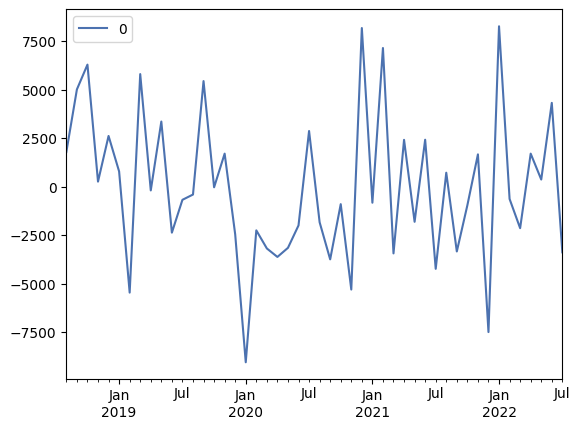

In [81]:
# now check the residuals for stationarity
residuals = DataFrame(model_fit2.resid)
residuals.plot()
plt.show()

In [82]:
residuals.describe()

,0
count,48.000000
mean,-31.760014
std,3904.800747
min,-9056.163860
25%,-2630.973967
50%,-514.805387
75%,2423.307594
max,8281.875073


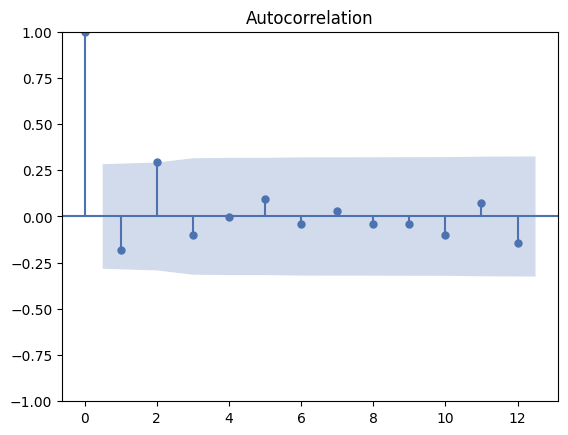

In [83]:
plot_acf(residuals,lags=12)
pyplot.show()

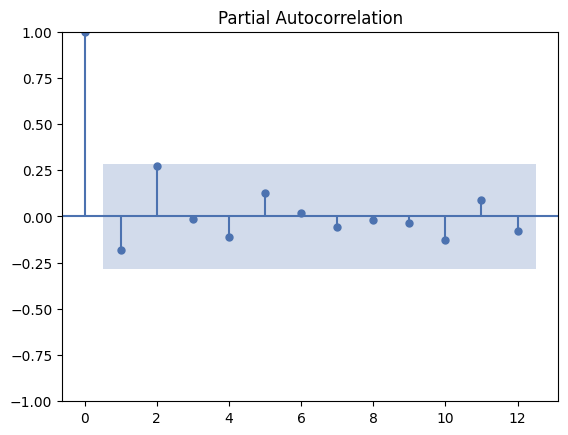

In [84]:
plot_pacf(residuals,lags=12)
pyplot.show()

In [85]:
# Perform the Ljung-Box test
lb_test = diag.acorr_ljungbox(model_fit2.resid, lags=[10], model_df=4)
print(lb_test)

     lb_stat  lb_pvalue
10  8.214229   0.222825


#### Takeaways:
- this model was more performant in terms of AIC, but less performant in terms in BIC
- spikes at 2 on both ACF plot and PACF plot. They are right on the edge of the confidence interval - meaning there may still be some remaining autocorrelation in the data
- the LB test had a much hihger p-value, which is better

#### Auto Search ARIMA

In [86]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import pandas as pd

df3 = pd.DataFrame({
    'unique_id':[1]*len(df2),
    'ds':df2.index,
    'y':df['y_deszn']
})

model3 = StatsForecast(models = [AutoARIMA(seasonal=False)], freq = 'M')
model3_fit = model3.fit(df = df3)

In [87]:
model3.fitted_[0][0].model_.get("arma")

(1, 1, 0, 0, 1, 1, 0)

In [88]:
model3.fitted_[0][0].model_.get("coef")

{'ar1': -0.412738126118347, 'ma1': -0.500497212044481}

In [89]:
model3.fitted_[0][0].model_.get("aic")

914.4142192920524

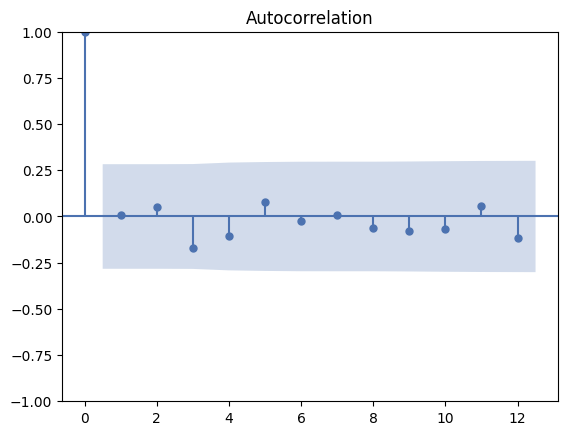

In [90]:
resid=model3.fitted_[0][0].model_.get("residuals")

plot_acf(resid,lags=12)
pyplot.show()

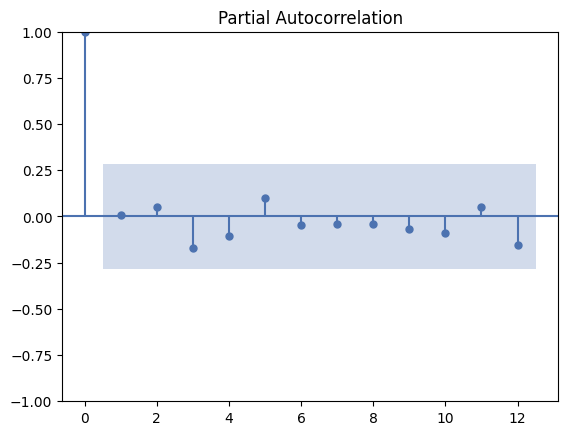

In [91]:
plot_pacf(resid,lags=12)
pyplot.show()

In [92]:
# Perform the Ljung-Box test
lb_test = diag.acorr_ljungbox(resid, lags=[10], model_df=2)
print(lb_test)

    lb_stat  lb_pvalue
10  3.56109   0.894397


#### Takeaways:
- this model is fitting seasonal terms and that's not allowed. It is disqulaified

### Predictions on Validation Set for best two Models

#### Model 1 Prediction Accuracy

In [93]:
## Model 1
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(df2, order=(2,0,2))
model1_fit = model1.fit()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [94]:
y_hat1 = model1_fit.forecast(steps=12)

In [95]:
y_hat1

2022-08-01    108223.668744
2022-09-01    105602.944354
2022-10-01    107025.149535
2022-11-01    106184.981702
2022-12-01    106626.923347
2023-01-01    106354.711476
2023-02-01    106489.762529
2023-03-01    106399.900859
2023-04-01    106439.803419
2023-05-01    106409.180438
2023-06-01    106420.136455
2023-07-01    106409.159895
Freq: MS, Name: predicted_mean, dtype: float64

In [96]:
mod1_preds = pd.DataFrame(y_hat1)
mod1_preds

,predicted_mean
2022-08-01,108223.668744
2022-09-01,105602.944354
2022-10-01,107025.149535
2022-11-01,106184.981702
2022-12-01,106626.923347
2023-01-01,106354.711476
2023-02-01,106489.762529
2023-03-01,106399.900859
2023-04-01,106439.803419
2023-05-01,106409.180438


In [97]:
seasonal_df = pd.DataFrame(seasonal)

In [98]:
mod1_preds['seasonal'] = seasonal_df['seasonal'].values[:12]
mod1_preds['full_pred'] = mod1_preds['predicted_mean'] + mod1_preds['seasonal']
mod1_preds

,predicted_mean,seasonal,full_pred
2022-08-01,108223.668744,4035.687353,112259.356097
2022-09-01,105602.944354,-5765.965629,99836.978725
2022-10-01,107025.149535,-13255.138373,93770.011162
2022-11-01,106184.981702,915.884826,107100.866528
2022-12-01,106626.923347,8285.156090,114912.079437
2023-01-01,106354.711476,20542.213606,126896.925082
2023-02-01,106489.762529,13602.624806,120092.387334
2023-03-01,106399.900859,-1852.702894,104547.197964
2023-04-01,106439.803419,-13893.401634,92546.401785
2023-05-01,106409.180438,-12933.845923,93475.334514


In [99]:
#yhat=y_hat1.reset_index(drop=True)
validate = v
abs_error= np.absolute(v['y']-mod1_preds["full_pred"])
MAE = np.mean(abs_error)
MAE

5570.783300167058

In [100]:
MAPE = np.mean(abs_error/np.absolute(v['y']))
MAPE

0.053016589059218446

#### Model 2 Prediction Accuracy

In [101]:
## Model 2
from statsmodels.tsa.arima.model import ARIMA

model2 = ARIMA(df2, order=(1,0,1))
model2_fit = model2.fit()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [102]:
y_hat2 = model2_fit.forecast(steps=12)

In [103]:
mod2_preds = pd.DataFrame(y_hat2)
mod2_preds['seasonal'] = seasonal_df['seasonal'].values[:12]
mod2_preds['full_pred'] = mod2_preds['predicted_mean'] + mod2_preds['seasonal']
mod2_preds

,predicted_mean,seasonal,full_pred
2022-08-01,106419.346296,4035.687353,110455.033649
2022-09-01,106417.301485,-5765.965629,100651.335856
2022-10-01,106415.511765,-13255.138373,93160.373391
2022-11-01,106413.945312,915.884826,107329.830138
2022-12-01,106412.574275,8285.156090,114697.730365
2023-01-01,106411.374274,20542.213606,126953.587880
2023-02-01,106410.323974,13602.624806,120012.948780
2023-03-01,106409.404699,-1852.702894,104556.701805
2023-04-01,106408.600103,-13893.401634,92515.198470
2023-05-01,106407.895881,-12933.845923,93474.049958


In [104]:
validate = v
abs_error= np.absolute(v['y']-mod2_preds["full_pred"])
MAE = np.mean(abs_error)
MAE

5469.3393835005945

In [105]:
MAPE = np.mean(abs_error/np.absolute(v['y']))
MAPE

0.052047056041444904

In [106]:
v_df = pd.DataFrame(v)
v_df

,unique_id,ds,y
2022-08-01,1,2022-08-01,107211.740742
2022-09-01,1,2022-09-01,95661.727133
2022-10-01,1,2022-10-01,91885.932581
2022-11-01,1,2022-11-01,102359.185867
2022-12-01,1,2022-12-01,122064.632290
2023-01-01,1,2023-01-01,114472.466839
2023-02-01,1,2023-02-01,107115.256286
2023-03-01,1,2023-03-01,103588.775710
2023-04-01,1,2023-04-01,89729.572067
2023-05-01,1,2023-05-01,90823.615226


### Visualize the Predictions

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

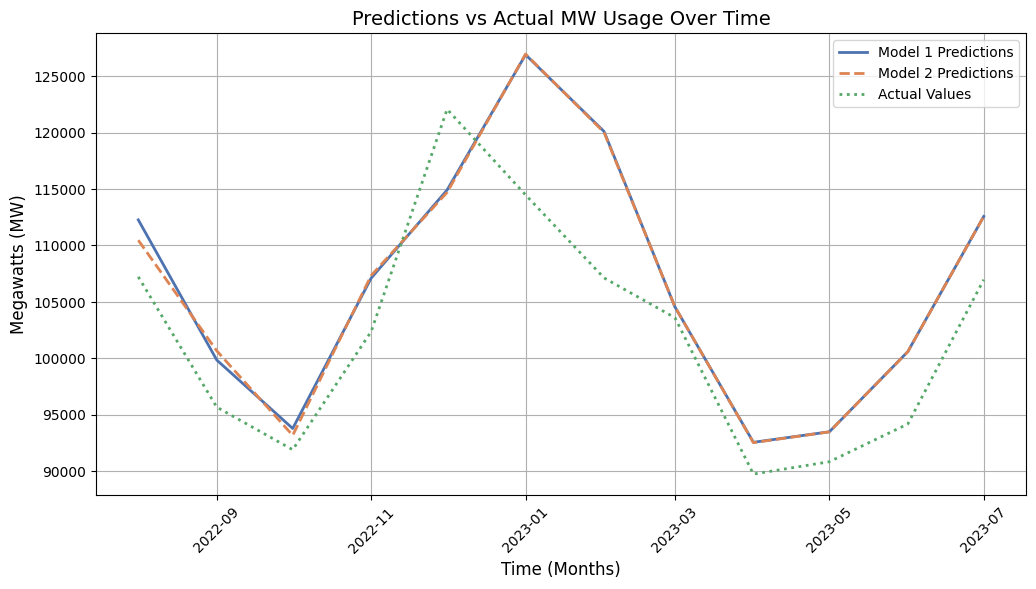

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Plot the first model's predictions
sns.lineplot(data=mod1_preds, x=mod1_preds.index, y='full_pred', label='Model 1 Predictions', linewidth=2)

# Plot the second model's predictions
sns.lineplot(data=mod2_preds, x=mod2_preds.index, y='full_pred', label='Model 2 Predictions', linewidth=2, linestyle='--')

# Plot the actual values
sns.lineplot(data=v_df, x=v_df.index, y='y', label='Actual Values', linewidth=2, linestyle=':')

# Customize the x-axis label
plt.xlabel("Time (Months)", fontsize=12)

# Customize the y-axis label
plt.ylabel("Megawatts (MW)", fontsize=12)

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Add gridlines
plt.grid(True)

# Add a title
plt.title("Predictions vs Actual MW Usage Over Time", fontsize=14)

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()
